In [1]:
%load_ext autoreload
%autoreload 2

import glob
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path


import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models  import resnet101, ResNet101_Weights
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
from pathlib import Path
import os
# from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

#Import required modules
from sklearn.decomposition import PCA
 

import matplotlib.patches as patches
from PIL import Image
import ast  # For literal_eval to convert string to dictionary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [2]:
np.random.seed(31101995)
torch.manual_seed(31101995)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# Set seed
seed_everything(31101995)

# 1. Load data

> 1. annotation.json
> 2. Convert to dataframe

In [3]:
# Assuming your JSON file is named 'your_file.json'
json_file_path = '/home/shsingh/knowledge_distillation/Car_damage_detection/0Train_via_annos.json'

def get_image_path(x):
    image_root_path = '/home/shsingh/knowledge_distillation/Car_damage_detection/image/image'
    return f'{image_root_path}/{x}'


# Load JSON file into a DataFrame
df = pd.read_json(json_file_path)
df = df.T.reset_index(drop=True)
df['image_path'] = df['name'].apply(lambda x: get_image_path(x))
df

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  
0      /home/shsingh/knowledge_distillation/Car_damag...  
1      /home/shsingh/knowledge_distillation/Car_damag...  
2      /home/shsingh/knowledge_distillation/Car_damag...  
3      /home/shsingh/knowledge_distillation/Car_damag...  
4      /home/shsingh/knowledge_distillation/Car_damag...  
...                                                  ...  
11616  /home/shsingh/knowledge_distillation/Car_damag...  
11617  /home/shsingh/knowledge_distillation/Car_damag...  
11618  /home/shsingh/knowledge_distillation/Car_damag...  
11619  /home/shsingh/knowledge_distillation/Car_damag...  
11620  /home/shsingh/knowledge_distillation/Car_damag...  

[11621 rows x 3 columns]

In [4]:
# df['regions'][0]

# 2. Plot instance with annoatations(damage)

In [ ]:
print(df[0:1]['regions'])

(600, 800, 3)
Text(496, 144, 'be_den')
Text(449, 301, 'mop_lom')


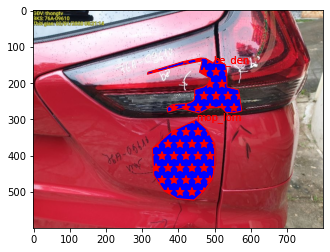

(600, 800, 3)
Text(514, 168, 'be_den')
Text(327, 598, 'mop_lom')


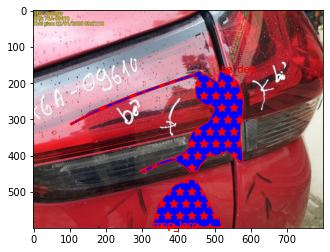

In [4]:
# Function to plot images with annotations
def plot_images_with_annotations(dataframe):
    for index, row in dataframe.iterrows():
        # Load the image
        image_path = row['image_path']
        img = Image.open(image_path)
        print(np.shape(img))
        
        # Create a figure and axes
        fig, ax = plt.subplots(1)
        # Display the image
        ax.imshow(img)
        # Retrieve annotations
        annotations = row['regions']
        for annotation in annotations:
            # Extract x and y coordinates
            all_x = annotation['all_x']
            all_y = annotation['all_y']
            # Create a polygon patch
            poly = patches.Polygon(list(zip(all_x, all_y)), edgecolor='r', facecolor='blue', hatch = '*')
            # Add the polygon to the axes
            ax.add_patch(poly)
            # Get the class name
            class_name = annotation['class']
            # Display the class name near the annotation
            ax.text(all_x[0], all_y[0], class_name, color='r')
            print(ax.text(all_x[0], all_y[0], class_name, color='r'))
        # Show the plot
        plt.show()

# Plot images with annotations
plot_images_with_annotations(df.loc[100:101])

# 3. EDA : set threshold for high, modrate, low and no damage

In [10]:
def calculate_polygon_area(all_x, all_y):
#     print(all_x, all_y)
    n = len(all_x)
    area = 0.5 * abs(sum(all_x[i] * all_y[(i + 1) % n] - all_y[i] * all_x[(i + 1) % n] for i in range(n)))
    return area


In [11]:
# Calculate total damaged area for each image
df['total_damage_area'] = df['regions'].apply(lambda x: sum(calculate_polygon_area(entry['all_x'], entry['all_y']) for entry in x))

# Display the resulting DataFrame
print(df[['name', 'total_damage_area']])

                                                    name  total_damage_area
0                         01012020_172204image853193.jpg           156392.0
1                         01012020_172204image891741.jpg           237672.5
2                          01012020_172251image12370.jpg           224911.0
3                         01022020_083952image768902.jpg           676724.0
4                         01022020_102246image365727.jpg           662169.5
...                                                  ...                ...
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...            70403.0
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...          1201401.0
11618  z2247452590065_f564385937849ea15551c31edd6a841...            19887.5
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...           223878.5
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...           395520.0

[11621 rows x 2 columns]


In [5]:
import cv2
import numpy as np
import pandas as pd

# Function to calculate area from polygon coordinates
def calculate_polygon_area(all_x, all_y):
    points = np.array(list(zip(all_x, all_y)), dtype=np.int32)
    points = points.reshape((-1, 1, 2))
    area = cv2.contourArea(points)
    return area

In [6]:
# Create a new column for total damaged area
df['total_damage_area_cv2'] = df['regions'].apply(lambda x: sum(calculate_polygon_area(entry['all_x'], entry['all_y']) for entry in x))

# Display the resulting DataFrame
# print(df[['name', 'total_damage_area_cv2']])
df


name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11616  /home/shsingh/knowledge_distillation/Car_damag...   
11617  /home/shsingh/knowledge_distillation/Car_damag...   
11618  /home/shsingh/knowledge_distillation/Car_damag...   
11619  /home/shsingh/knowledge_distillation/Car_damag...   
11620  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  
0                   156392.0  
1                   237672.5  
2                   224911.0  
3                   676724.0  
4                   662169.5  
...                      ...  
11616                70403.0  
11617              1201401.0  
11618                19887.5  
11619               223878.5  
11620               395520.0  

[11621 rows x 4 columns]

In [7]:
# Calculate statistical summary for total_damage_area_cv2
statistical_summary = df['total_damage_area_cv2'].describe()

# Display the statistical summary
print(statistical_summary)

count    1.162100e+04
mean     2.922193e+05
std      4.912562e+05
min      1.500000e+00
25%      2.589250e+04
50%      9.815250e+04
75%      3.112050e+05
max      3.155164e+06
Name: total_damage_area_cv2, dtype: float64


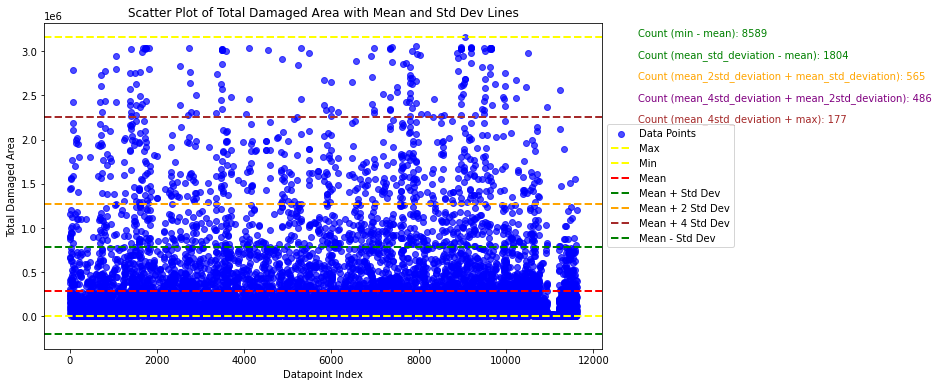

In [8]:
# # Calculate mean and standard deviation
mean_value = df['total_damage_area_cv2'].mean()
std_deviation = df['total_damage_area_cv2'].std()
max_val = df['total_damage_area_cv2'].max()
min_val = df['total_damage_area_cv2'].min()

mean_std_deviation = mean_value + std_deviation
mean_2std_deviation = mean_value + 2*std_deviation
mean_3std_deviation =  mean_value + 3*std_deviation
mean_4std_deviation =  mean_value + 4*std_deviation

plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['total_damage_area_cv2'], color='blue', alpha=0.7, label='Data Points')


plt.axhline(max_val, color='yellow', linestyle='dashed', linewidth=2, label='Max')
plt.axhline(min_val, color='yellow', linestyle='dashed', linewidth=2, label='Min')
plt.axhline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axhline(mean_std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean + Std Dev')
plt.axhline(mean_2std_deviation, color='orange', linestyle='dashed', linewidth=2, label='Mean + 2 Std Dev')
# plt.axhline(mean_3std_deviation, color='purple', linestyle='dashed', linewidth=2, label='Mean + 3 Std Dev')
plt.axhline(mean_4std_deviation, color='brown', linestyle='dashed', linewidth=2, label='Mean + 4 Std Dev')
plt.axhline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean - Std Dev')


count_mean_min = df[(df['total_damage_area_cv2'] >=min_val) & (df['total_damage_area_cv2'] <=mean_value )].shape[0]
count_mean_mean_plus_std = df[(df['total_damage_area_cv2'] >mean_value) & (df['total_damage_area_cv2'] <= mean_std_deviation)].shape[0]
count_mean_plus_std_mean_plus_2std =  df[(df['total_damage_area_cv2'] >mean_std_deviation) & (df['total_damage_area_cv2'] <= mean_2std_deviation)].shape[0]
count_mean_plus_2std_mean_plus_4std = df[(df['total_damage_area_cv2'] >mean_2std_deviation) & (df['total_damage_area_cv2'] <= mean_4std_deviation)].shape[0]
count_mean_plus_4std_max =  df[(df['total_damage_area_cv2'] >mean_4std_deviation) & (df['total_damage_area_cv2'] <=max_val)].shape[0]

# Display counts as text outside the plot
plt.text(0.95, 0.85, f'Count (min - mean): {count_mean_min}', transform=plt.gcf().transFigure, color='green')
plt.text(0.95, 0.80, f'Count (mean_std_deviation - mean): {count_mean_mean_plus_std}', transform=plt.gcf().transFigure, color='green')
plt.text(0.95, 0.75, f'Count (mean_2std_deviation + mean_std_deviation): {count_mean_plus_std_mean_plus_2std}', transform=plt.gcf().transFigure, color='orange')
plt.text(0.95, 0.70, f'Count (mean_4std_deviation + mean_2std_deviation): {count_mean_plus_2std_mean_plus_4std}', transform=plt.gcf().transFigure, color='purple')
plt.text(0.95, 0.65, f'Count (mean_4std_deviation + max): {count_mean_plus_4std_max}', transform=plt.gcf().transFigure, color='brown')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Scatter Plot of Total Damaged Area with Mean and Std Dev Lines')
plt.xlabel('Datapoint Index')
plt.ylabel('Total Damaged Area')
plt.show()


In [51]:
# # # Calculate mean and standard deviation
# mean_value = df['total_damage_area_cv2'].mean()
# std_deviation = df['total_damage_area_cv2'].std()
# max_val = df['total_damage_area_cv2'].max()
# min_val = df['total_damage_area_cv2'].min()

# # Calculate mean and standard deviation
# # mean_value = df['normalized_damage_area'].mean()
# # std_deviation = df['normalized_damage_area'].std()
# # max_val = df['normalized_damage_area'].max()
# # min_val = df['normalized_damage_area'].min()


# mean_std_deviation = mean_value + std_deviation
# mean_2std_deviation = mean_value + 2*std_deviation
# mean_3std_deviation =  mean_value + 3*std_deviation
# mean_4std_deviation =  mean_value + 4*std_deviation

# # Create a scatter plot with mean and standard deviation lines
# plt.figure(figsize=(10, 6))
# plt.scatter(df.index, df['normalized_damage_area'], color='blue', alpha=0.7)
# plt.axhline(max_val, color='yellow', linestyle='dashed', linewidth=2, label='Max')
# plt.axhline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
# plt.axhline(min_val, color='yellow', linestyle='dashed', linewidth=2, label='Min')
# plt.axhline(mean_std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean + Std Dev')

# plt.axhline(mean_2std_deviation, color='green', linestyle='dashed', linewidth=2, label='2*Mean + Std Dev')
# # plt.axhline(mean_3std_deviation, color='green', linestyle='dashed', linewidth=2, label='3*Mean + Std Dev')
# plt.axhline(mean_4std_deviation, color='green', linestyle='dashed', linewidth=2, label='4*Mean + Std Dev')

# plt.axhline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean - Std Dev')
# plt.title('Scatter Plot of Total Damaged Area with Mean and Std Dev Lines')
# plt.xlabel('Datapoint Index')
# plt.ylabel('Total Damaged Area')
# plt.legend()
# plt.show()

In [9]:
print('max_val:', max_val)
print('mean_value:',mean_value)
print('min_val:',min_val)
print('mean_std_deviation:',mean_std_deviation)
print('mean_2std_deviation:',mean_2std_deviation)
print('mean_3std_deviation:',mean_3std_deviation)
print('mean_4std_deviation:',mean_4std_deviation)


max_val: 3155164.0
mean_value: 292219.32785474573
min_val: 1.5
mean_std_deviation: 783475.4971475987
mean_2std_deviation: 1274731.6664404515
mean_3std_deviation: 1765987.8357333045
mean_4std_deviation: 2257244.0050261575


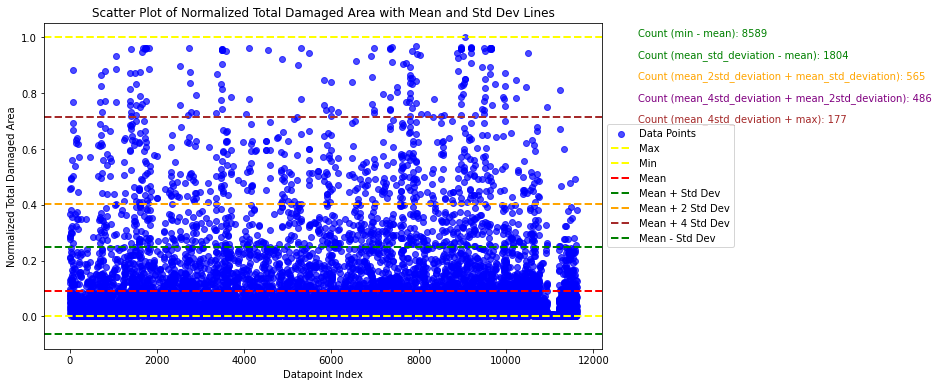

In [48]:

# from sklearn.preprocessing import MinMaxScaler

# # Normalize the total_damage_area_cv2 column
# scaler = MinMaxScaler()
# df['normalized_damage_area'] = scaler.fit_transform(df[['total_damage_area_cv2']])

# Calculate additional standard deviations
# mean_2std_deviation = mean_value + 2 * std_deviation
# mean_3std_deviation = mean_value + 3 * std_deviation
# mean_4std_deviation = mean_value + 4 * std_deviation

# Create a scatter plot with normalized values and mean/std dev lines
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['normalized_damage_area'], color='blue', alpha=0.7, label='Data Points')

plt.axhline(max_val, color='yellow', linestyle='dashed', linewidth=2, label='Max')
plt.axhline(min_val, color='yellow', linestyle='dashed', linewidth=2, label='Min')
plt.axhline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axhline(mean_std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean + Std Dev')
plt.axhline(mean_2std_deviation, color='orange', linestyle='dashed', linewidth=2, label='Mean + 2 Std Dev')
# plt.axhline(mean_3std_deviation, color='purple', linestyle='dashed', linewidth=2, label='Mean + 3 Std Dev')
plt.axhline(mean_4std_deviation, color='brown', linestyle='dashed', linewidth=2, label='Mean + 4 Std Dev')
plt.axhline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean - Std Dev')
# # Count data points within each interval
# count_mean_plus_std = df[df['normalized_damage_area'] > (mean_value + std_deviation)].shape[0]
# count_mean_minus_std = df[df['normalized_damage_area'] < (mean_value - std_deviation)].shape[0]
# count_mean_plus_2std = df[df['normalized_damage_area'] > mean_2std_deviation].shape[0]
# count_mean_plus_3std = df[df['normalized_damage_area'] > mean_3std_deviation].shape[0]
# count_mean_plus_4std = df[df['normalized_damage_area'] > mean_4std_deviation].shape[0]



count_mean_min = df[(df['normalized_damage_area'] >=min_val) & (df['normalized_damage_area'] <=mean_value )].shape[0]
count_mean_mean_plus_std = df[(df['normalized_damage_area'] >mean_value) & (df['normalized_damage_area'] <= mean_std_deviation)].shape[0]
count_mean_plus_std_mean_plus_2std =  df[(df['normalized_damage_area'] >mean_std_deviation) & (df['normalized_damage_area'] <= mean_2std_deviation)].shape[0]
count_mean_plus_2std_mean_plus_4std = df[(df['normalized_damage_area'] >mean_2std_deviation) & (df['normalized_damage_area'] <= mean_4std_deviation)].shape[0]
count_mean_plus_4std_max =  df[(df['normalized_damage_area'] >mean_4std_deviation) & (df['normalized_damage_area'] <=max_val)].shape[0]

# Display counts as text outside the plot
plt.text(0.95, 0.85, f'Count (min - mean): {count_mean_min}', transform=plt.gcf().transFigure, color='green')
plt.text(0.95, 0.80, f'Count (mean_std_deviation - mean): {count_mean_mean_plus_std}', transform=plt.gcf().transFigure, color='green')
plt.text(0.95, 0.75, f'Count (mean_2std_deviation + mean_std_deviation): {count_mean_plus_std_mean_plus_2std}', transform=plt.gcf().transFigure, color='orange')
plt.text(0.95, 0.70, f'Count (mean_4std_deviation + mean_2std_deviation): {count_mean_plus_2std_mean_plus_4std}', transform=plt.gcf().transFigure, color='purple')
plt.text(0.95, 0.65, f'Count (mean_4std_deviation + max): {count_mean_plus_4std_max}', transform=plt.gcf().transFigure, color='brown')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Scatter Plot of Normalized Total Damaged Area with Mean and Std Dev Lines')
plt.xlabel('Datapoint Index')
plt.ylabel('Normalized Total Damaged Area')
plt.show()


# 4. Prepare dataset


>  1. Use the total_area_damaged to assign label
>  2. Use threshold to decide the categorgy
</item>

In [10]:
# Define the conditions and corresponding labels
conditions = [
    (df['total_damage_area_cv2'] >= min_val) & (df['total_damage_area_cv2'] <= mean_value),
    (df['total_damage_area_cv2'] > mean_value) & (df['total_damage_area_cv2'] <= mean_std_deviation),
    (df['total_damage_area_cv2'] > mean_std_deviation) & (df['total_damage_area_cv2'] <= mean_2std_deviation),
    (df['total_damage_area_cv2'] > mean_2std_deviation) & (df['total_damage_area_cv2'] <= mean_4std_deviation),
    (df['total_damage_area_cv2'] > mean_4std_deviation) & (df['total_damage_area_cv2'] <= max_val)
]

# Define the corresponding labels
labels = ['low_average', 'low_moderate', 'moderate', 'high', 'critical']

# Create a new column 'label' based on the conditions and labels
df['damage_label'] = np.select(conditions, labels, default='unknown')
df

name  \
0                         01012020_172204image853193.jpg   
1                         01012020_172204image891741.jpg   
2                          01012020_172251image12370.jpg   
3                         01022020_083952image768902.jpg   
4                         01022020_102246image365727.jpg   
...                                                  ...   
11616  z2243796268779_2cadfc39a0bc5c92fa2b6d6560699ae...   
11617  z2246123119712_3cb5dbd5a8628e87dabe68e7f25c754...   
11618  z2247452590065_f564385937849ea15551c31edd6a841...   
11619  z2613326143146_1a2ac98d506eab5651d5a79a70cbd91...   
11620  z2669260231605_44c66996f57e4127d3b692ed7cf8c2d...   

                                                 regions  \
0      [{'all_x': [1, 30, 81, 79, 74, 65, 63, 65, 83,...   
1      [{'all_x': [-1, 2, 41, 107, 127, 179, 200, 233...   
2      [{'all_x': [220, 212, 213, 224, 241, 253, 262,...   
3      [{'all_x': [228, 224, 229, 237, 231], 'all_y':...   
4      [{'all_x': [897, 866, 853, 873, 927, 945, 958,...   
...                                                  ...   
11616  [{'all_x': [618, 686, 847, 858, 816, 717, 572,...   
11617  [{'all_x': [420, 431, 440, 448, 440, 426, 420,...   
11618  [{'all_x': [-2, 130, 320, 426, 501, 525, 541, ...   
11619  [{'all_x': [469, 533, 780, 883, 906, 975, 1023...   
11620  [{'all_x': [92, 2, 0, 51, 128, 183, 263, 378, ...   

                                              image_path  \
0      /home/shsingh/knowledge_distillation/Car_damag...   
1      /home/shsingh/knowledge_distillation/Car_damag...   
2      /home/shsingh/knowledge_distillation/Car_damag...   
3      /home/shsingh/knowledge_distillation/Car_damag...   
4      /home/shsingh/knowledge_distillation/Car_damag...   
...                                                  ...   
11616  /home/shsingh/knowledge_distillation/Car_damag...   
11617  /home/shsingh/knowledge_distillation/Car_damag...   
11618  /home/shsingh/knowledge_distillation/Car_damag...   
11619  /home/shsingh/knowledge_distillation/Car_damag...   
11620  /home/shsingh/knowledge_distillation/Car_damag...   

       total_damage_area_cv2  damage_label  
0                   156392.0   low_average  
1                   237672.5   low_average  
2                   224911.0   low_average  
3                   676724.0  low_moderate  
4                   662169.5  low_moderate  
...                      ...           ...  
11616                70403.0   low_average  
11617              1201401.0      moderate  
11618                19887.5   low_average  
11619               223878.5   low_average  
11620               395520.0  low_moderate  

[11621 rows x 5 columns]

# 5. UMAP Visualization

Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/02012020_082351image833616.jpg: image file is truncated (26 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04052020_152057image59498.jpg: broken data stream when reading image file
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04052020_152101image628633.jpg: broken data stream when reading image file
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/04052020_152107image748519.jpg: image file is truncated (0 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13032020_144737image20659.jpg: image file is truncated (0 bytes not processed)
Error loading image /home/shsingh/knowledge_distillation/Car_damage_detection/image/image/13032020_144742image419520.jpg: broken data stream when reading image f

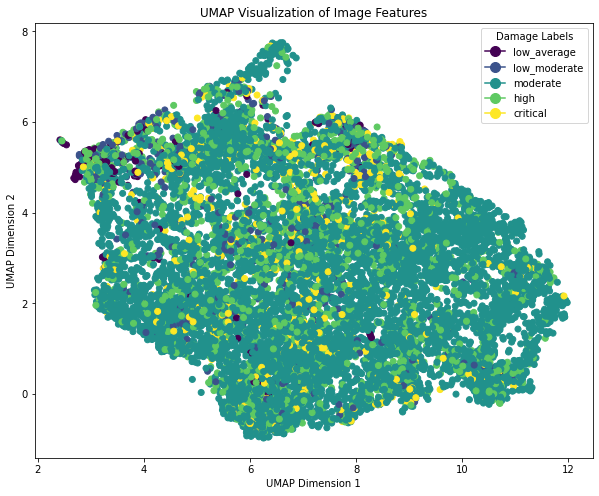

In [11]:
import torch
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
# from sklearn.manifold import UMAP
from umap import UMAP
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Load the Vision Transformer model
vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
preprocessing = ViT_B_16_Weights.DEFAULT.transforms()

# Load your DataFrame with image paths and damage labels
# Assume your DataFrame has columns: 'image_path' and 'damage_label'
# Make sure 'damage_label' is the column you want to visualize

# Function to extract features from an image
def extract_features(image_path):
    try:   
        img = Image.open(image_path).convert('RGB')
        img = img.resize((256,256))
        img = preprocessing(img)
        img = img.unsqueeze(0)
        feats = vit._process_input(img)
        batch_class_token = vit.class_token.expand(img.shape[0], -1, -1)
        feats = torch.cat([batch_class_token, feats], dim=1)
        feats = vit.encoder(feats)
        feats = feats[:, 0]
#         print('feats:',np.shape(feats))
        return feats.flatten().detach().numpy()
    except (IOError, OSError) as e:
        print(f"Error loading image {image_path}: {e}")

# df_subset = df[0:1000]
df_subset = df.copy()
# Apply the function to extract features for each image in the DataFrame
df_subset['image_features'] = df_subset['image_path'].apply(extract_features)

# Filter out rows with None values in 'image_features'
df_subset = df_subset[df_subset['image_features'].notna()]

print(np.unique([np.shape(i for i in df_subset['image_features'])]))
# Extract the features and labels for UMAP
features_matrix = np.stack(df_subset['image_features'])
flattened_features = features_matrix.reshape(features_matrix.shape[0], -1)

labels = LabelEncoder().fit_transform(df_subset['damage_label'])

# Apply UMAP for dimensionality reduction and visualization
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(features_matrix)

# Plot the UMAP visualization with class labels and legend
plt.figure(figsize=(10, 8))

scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis')

# Create custom legend handles
legend_handles = [Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(i)), markersize=10, label=label) for i, label in enumerate(df_subset['damage_label'].unique())]

plt.title('UMAP Visualization of Image Features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Add custom legend with handles
plt.legend(handles=legend_handles, title='Damage Labels', loc='upper right')

plt.show()

# 6. Scrap/draft cells

In [71]:
failed=[img for img in df['name'] if '.jpg'  in img ]

# for img in df['name']:
#     if '.jpg' not in img:
#         failed.append(img)
        
len(failed)

11621

In [ ]:
import segmentation_models_pytorch as smp
from torchvision.models import resnet18, resnet50, vit_b_16, convnext_tiny, densenet121, efficientnet_v2_s,maxvit_t, swin_t


# model = smp.Unet(
#     encoder_name='resnet50',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=3,                      # model output channels (number of classes in your dataset)
# )
model = resnet50(pretrained=True)
print(model)

In [16]:
from umap import UMAP

In [8]:
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights

from PIL import Image as PIL_Image

vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
preprocessing = ViT_B_16_Weights.DEFAULT.transforms()

img = PIL_Image.open("/home/shsingh/knowledge_distillation/Car_damage_detection/image/image/1bce3ad248eab0b4e9fb.jpg")
img = preprocessing(img)

# Add batch dimension
img = img.unsqueeze(0)

feats = vit._process_input(img)

# Expand the class token to the full batch
batch_class_token = vit.class_token.expand(img.shape[0], -1, -1)
feats = torch.cat([batch_class_token, feats], dim=1)

feats = vit.encoder(feats)

# We're only interested in the representation of the classifier token that we appended at position 0
feats = feats[:, 0]

print(feats.shape)

torch.Size([1, 768])


(100, 1, 768)
[[[ 0.5452491   0.548168   -0.23525742 ...  0.71631455  0.45178616
    1.6072515 ]]

 [[-0.0073203   0.6114894   0.901493   ...  1.5928451   0.8906364
    1.49945   ]]

 [[-0.19954658 -0.2618702   0.14816743 ...  1.6533161  -0.09100567
    2.9223661 ]]

 ...

 [[ 0.11094566  0.6641843  -0.8465162  ...  1.2315588   0.47085539
    1.1906519 ]]

 [[ 0.3875464  -0.261544   -0.76911914 ...  0.3956537   0.73612463
    1.6707238 ]]

 [[ 0.06273381 -0.15120634 -0.22387476 ...  1.672766    0.32868052
    1.2846278 ]]]
(100, 768)


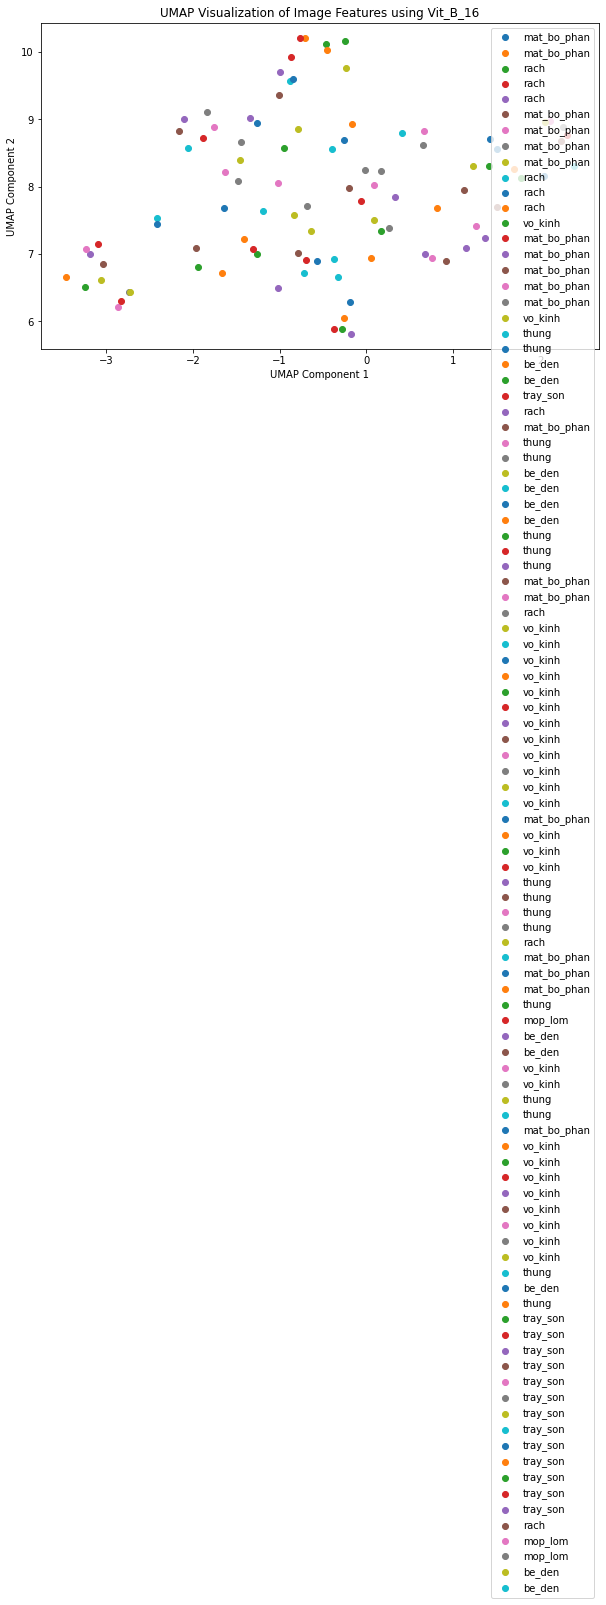

In [14]:
vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
preprocessing = ViT_B_16_Weights.DEFAULT.transforms()

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = preprocessing(img)
    return img

# Process all images in the DataFrame
image_features = []

df_subset = df[0:100].reset_index(drop=True)

for index, row in df_subset.iterrows():
#     img_path = os.path.join("/home/shsingh/knowledge_distillation/Car_damage_detection/image/image/", row['image_name'])
    img_path = row['image_path']
    img = load_and_preprocess_image(img_path)

    # Add batch dimension
    img = img.unsqueeze(0)

    feats = vit._process_input(img)

    # Expand the class token to the full batch
    batch_class_token = vit.class_token.expand(img.shape[0], -1, -1)
    feats = torch.cat([batch_class_token, feats], dim=1)

    feats = vit.encoder(feats)

    # We're only interested in the representation of the classifier token that we appended at position 0
    feats = feats[:, 0]

    image_features.append(feats.detach().numpy() )

# Stack feature vectors into a matrix
features_matrix = np.stack(image_features, axis=0)
print(np.shape(features_matrix))
print(features_matrix)
# Flatten the feature matrix
flattened_features = features_matrix.reshape(features_matrix.shape[0], -1)
print(np.shape(flattened_features))

# Encode class labels using LabelEncoder
label_encoder = LabelEncoder()
df_subset['encoded_class'] = label_encoder.fit_transform(df_subset['regions'].apply(lambda x: x[0]['class']))

# Apply UMAP for dimensionality reduction and visualization
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(flattened_features)

# Plot the UMAP visualization with class labels
plt.figure(figsize=(10, 6))
for index, row in df_subset.iterrows():
    plt.scatter(umap_result[index, 0], umap_result[index, 1], label=row['regions'][0]['class'])

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Image Features using Vit_B_16')
plt.legend()
plt.show()



# Problem:

1. Each instance/image has multiple annotataions i.e. multiple classes
2. Visulaize:
    a. Each data-point as an image
    b. Each class from each image as a datapoint. BUT the features used to project the UMAP are extracted from each image not 
    w.r.t. the classes!?

In [25]:

vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
preprocessing = ViT_B_16_Weights.DEFAULT.transforms()

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = PIL_Image.open(image_path)
    img = preprocessing(img)
    return img

# Process all images in the DataFrame
image_features = []

# Create a dictionary to map classes to colors
class_color_mapping = {}
df_subset = df[0:100].reset_index(drop=True)

for index, row in df_subset.iterrows():
    img_path = row['image_path']
    img = load_and_preprocess_image(img_path)

    # Add batch dimension
    img = img.unsqueeze(0)

    feats = vit._process_input(img)

    # Expand the class token to the full batch
    batch_class_token = vit.class_token.expand(img.shape[0], -1, -1)
    feats = torch.cat([batch_class_token, feats], dim=1)

    feats = vit.encoder(feats)

    # We're only interested in the representation of the classifier token that we appended at position 0
    feats = feats[:, 0]

    image_features.append(feats.detach().numpy())
    
     # Assign a distinct color to each class
    if row['regions'][0]['class'] not in class_color_mapping:
        class_color_mapping[row['regions'][0]['class']] = len(class_color_mapping)

#     # If the class is not already in the mapping, assign a new color
#     if row['regions'][0]['class'] not in class_color_mapping:
#         class_color_mapping[row['regions'][0]['class']] = plt.cm.get_cmap('tab10')(len(class_color_mapping))

# Stack feature vectors into a matrix
features_matrix = np.stack(image_features, axis=0)
# Flatten the feature matrix
flattened_features = features_matrix.reshape(features_matrix.shape[0], -1)
print(np.shape(flattened_features))


# Encode class labels using LabelEncoder
label_encoder = LabelEncoder()
df_subset['encoded_class'] = label_encoder.fit_transform(df_subset['regions'].apply(lambda x: x[0]['class']))

# Apply UMAP for dimensionality reduction and visualization
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(flattened_features)

# # Plot the UMAP visualization with consistent class colors
# legend_labels = set()
# for index, row in df_subset.iterrows():
#     label = row['regions'][0]['class']
#     plt.scatter(umap_result[index, 0], umap_result[index, 1], color=class_color_mapping[label], label=label)
#     legend_labels.add(label)

# # Plot legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', labels=legend_labels)
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('UMAP Visualization of Image Features using Vit_B_16')
# plt.show()

# plt.figure(figsize=(10, 6))
# for index, row in df_subset.iterrows():
#     label = row['regions'][0]['class']
#     color = class_color_mapping[label]
#     plt.scatter(umap_result[index, 0], umap_result[index, 1], c=color, label=label)

# # Plot legend outside the plot
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(color), markersize=10, label=label) for label, color in class_color_mapping.items()]
# plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('UMAP Visualization of Image Features using Vit_B_16')
# plt.show()

# Apply UMAP for dimensionality reduction and visualization
# umap = UMAP(n_components=2)
# umap_result = umap.fit_transform(features_matrix)

# Plot the UMAP visualization with distinct class colors for each data point
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=df_subset['encoded_class'], cmap='tab10', label=df_subset['regions'][0]['class'])

# Plot legend outside the plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(color), markersize=10, label=label) for label, color in class_color_mapping.items()]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Image Features using Vit_B_16')
plt.show()

(100, 768)


TypeError: list indices must be integers or slices, not str

<Figure size 720x432 with 0 Axes>

In [15]:
# from transformers import DinoModel, DinoTokenizer
from sklearn.preprocessing import LabelEncoder
from umap import UMAP
import os

In [ ]:
# Filter out non-image files
df['is_image'] = df['image_path'].apply(lambda x: os.path.splitext(x)[1].lower() in ['.jpg', '.jpeg', '.png'])
df = df[df['is_image']]
df_subset = df[0:2].reset_index(drop=True)
# Load images and convert them to numpy arrays
images = []
for img_path in df_subset['image_path']:
    try:
        img = Image.open(img_path).convert("L")
#         img = img.resize((256,256))
        img = img.resize((100, 100)) 
        images.append(np.array(img))
    except (IOError, OSError) as e:
        print(f"Error loading image {img_path}: {e}")

# Remove any images that failed to load
df_subset = df_subset.iloc[:len(images)]

# Reshape images to vectors
image_vectors = [img.flatten() for img in images]

# Stack vectors into a matrix
image_matrix = np.stack(image_vectors, axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_matrix)

# Add PCA results to DataFrame
df_subset['PCA1'] = pca_result[:, 0]
df_subset['PCA2'] = pca_result[:, 1]

# Plot PCA results
plt.figure(figsize=(10, 6))
for index, row in df.iterrows():
    plt.scatter(row['PCA1'], row['PCA2'], label=row['name'])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Image Data')
plt.legend()
plt.show()